## Libaries

In [1]:
# Main libraries installation
!pip install pyproject-toml h3 geopandas folium > nul

In [2]:
# Install or upgrade the 'kaleido' library for static image export from Plotly
# Note: This is commented out as it's optional and may not be necessary depending on the system.
# Uncomment and run these lines if there are issues with static image export.
# pip install -U kaleido

# Install or upgrade the 'plotly' library
# Note: This line is not commented out as it is a standard library required for Plotly functionality.
!pip install -U plotly

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Import necessary libraries
import h3  # Library for working with H3 hexagons
import pandas as pd  # Library for data manipulation and analysis
import geopandas as gpd  # Library for geospatial data manipulation and analysis
from shapely.geometry import Point, Polygon  # Library for handling geometric shapes
import folium  # Library for creating interactive maps
import json  # Library for working with JSON data
from shapely.geometry import mapping  # Library for converting Shapely geometries to GeoJSON-like dicts
import contextily as cx  # Library for basemaps and context tiles
import matplotlib.pyplot as plt  # Library for creating visualizations
import plotly.express as px  # Library for creating interactive visualizations
import warnings  # Library for managing warnings
warnings.filterwarnings("ignore")  # Ignore warnings during runtime
import plotly.io as pio  # Library for handling Plotly I/O
from IPython.display import Image  # Library for displaying images in IPython environment

## Data Ingestion

In [4]:
# Get the coordinates of the Eiffel Tower
torre_eiffel_coords = (48.858844, 2.294350)  # Latitude and longitude of the Eiffel Tower

In [5]:
# Create a DataFrame with information about the Eiffel Tower
place_dict = {'place': ['Eiffel Tower'], 'lat': [48.858844], 'long': [2.294350]}
df = pd.DataFrame(place_dict)

In [6]:
# Convert the CSV to a GeoDataFrame
gdf_puntos = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long, df.lat)
)

In [7]:
# Set a Coordinate Reference System (CRS) for the GeoDataFrame
gdf_puntos = gdf_puntos.set_crs(4326, allow_override=True)

In [8]:
# Convert points to H3 hexagons with resolution 9
resolution_h3 = 9

# Convert points to WGS84 projection
gdf_puntos = gdf_puntos.to_crs(epsg=4326)

# Add the `hex_id` column
gdf_puntos['hex_id'] = gdf_puntos['geometry'].apply(lambda geom: h3.geo_to_h3(geom.y, geom.x, resolution_h3))

In [9]:
# Function to get H3 hexagon of resolution 12 for the centroid of a polygon
def get_h3_for_polygon(polygon, resolution):
    centroid = polygon.centroid
    lat, lon = centroid.y, centroid.x
    hex_id = h3.geo_to_h3(lat, lon, resolution)
    return hex_id

In [10]:
# Add the `hex_id` column to gdf_puntos using the get_h3_for_polygon function
gdf_puntos['hex_id'] = gdf_puntos['geometry'].apply(lambda geom: get_h3_for_polygon(geom, resolution_h3))

In [11]:
# Display information about the GeoDataFrame gdf_puntos
gdf_puntos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   place     1 non-null      object  
 1   lat       1 non-null      float64 
 2   long      1 non-null      float64 
 3   geometry  1 non-null      geometry
 4   hex_id    1 non-null      object  
dtypes: float64(2), geometry(1), object(2)
memory usage: 168.0+ bytes


## Data exploring

In [12]:
# Get the boundaries of the H3 hexagon for each hexagon in the Series
hexagon_boundaries = []
for hex_id in gdf_puntos['hex_id']:
    hexagon_boundary = h3.h3_to_geo_boundary(hex_id)
    hexagon_boundaries.append(hexagon_boundary)

In [13]:
# Assuming hexagon_boundary is a list of coordinates [(lat, lon), ...]
hexagon_coordinates = [(lon, lat) for lat, lon in hexagon_boundary]

# Create a GeoDataFrame with the coordinates
hexagon_gdf = gpd.GeoDataFrame(geometry=[Polygon(hexagon_coordinates)], crs="EPSG:4326")

# Add H3 index and resolution
hexagon_gdf['h3_index'] = gdf_puntos['hex_id']
hexagon_gdf['resolution'] = resolution_h3

# Display the result
print(hexagon_gdf)

                                            geometry         h3_index  \
0  POLYGON ((2.29380 48.85912, 2.29181 48.85815, ...  891fb46741bffff   

   resolution  
0           9  


## Data Visualization

In [14]:
# Assuming hexagon_gdf is your GeoDataFrame with H3 hexagon
fig = px.choropleth_mapbox(hexagon_gdf,
                           geojson=hexagon_gdf.geometry.__geo_interface__,
                           locations=hexagon_gdf.index,
                           color='h3_index',  # Add H3 index to color
                           hover_data=['h3_index', 'resolution'],  # Add H3 index and resolution to hover
                           mapbox_style="carto-positron",
                           center={"lat": hexagon_gdf.geometry.centroid.y.mean(), "lon": hexagon_gdf.geometry.centroid.x.mean()},
                           zoom=15)

# Add transparency to the polygon
fig.update_traces(marker=dict(opacity=0.3, line=dict(width=0.5, color='White')))

# Add the Eiffel Tower point
scatter_trace = px.scatter_mapbox(gdf_puntos, 
                                  lat="lat",  # Name of the latitude column
                                  lon="long",  # Name of the longitude column
                                  text="place")  # Name of the column for text

# Update the point marker
scatter_trace.update_traces(marker=dict(color='red', size=10))

# Add the point to the plot
fig.add_trace(scatter_trace.data[0])

# Hide the index on the map
fig.update_layout(mapbox_layers=[{
    'below': 'traces',
    'sourcetype': 'geojson',
    'source': hexagon_gdf.geometry.__geo_interface__,
    'type': 'fill',
    'color': 'rgba(0,0,0,0)'  # Transparent color
}])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [15]:
# Assuming 'fig' is your Plotly figure
pio.write_html(fig, 'data/h3/mapa.html')

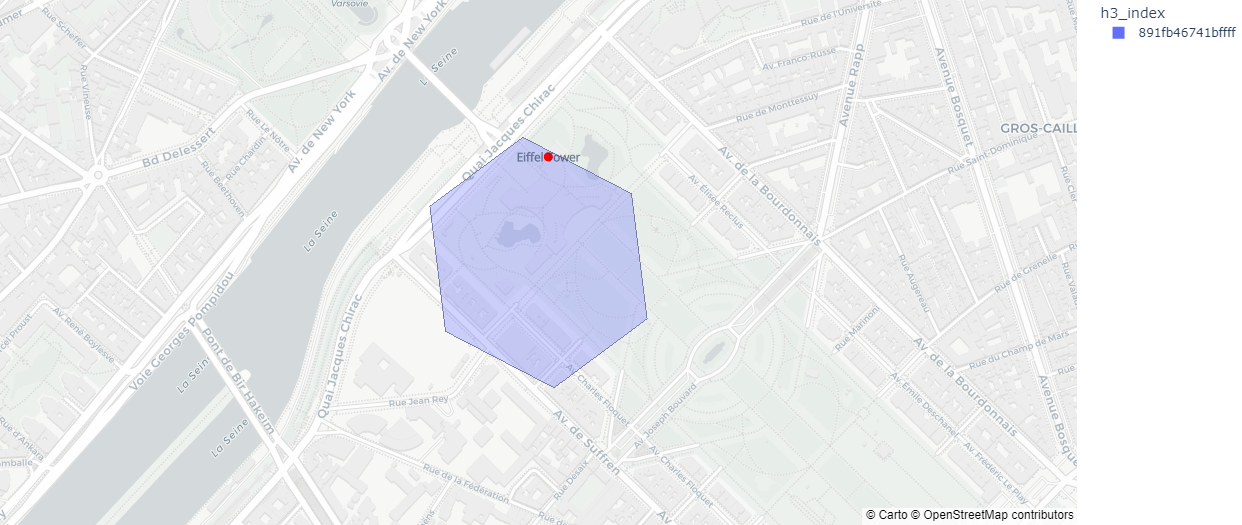

In [16]:
# Path to your PNG file
ruta_archivo_png = 'data/h3/h3hexagon.png'  # Replace with the correct path

# Display the image in the notebook
Image(filename=ruta_archivo_png)